In [1]:
import numpy as np
import scipy
import math
import random
import pandas as pd
from matplotlib import animation
import matplotlib as mpl
import seaborn as sns

from matplotlib.animation import FuncAnimation
import os
import time
from skspatial.objects import Sphere
from scipy.stats import uniform
from scipy.integrate import quad
import tqdm as tqdm

from matplotlib import pyplot as plt
from matplotlib import colormaps
%matplotlib inline
%config InlineBackend.figure_format='retina'

# Hernquist Density Profile
The density is given by (Galactic Dynamics, James Binney- pg 70):

$$
    \rho(r) = \frac{\rho_0 Rs^4}{r (r + Rs)^3}.
$$

where $Rs$ is the scale radius.

The mass within a given radius r is:

$$
    M(r) = \int_0^r \rho(r) 4 \pi r^2 dr = \dots = 4  \pi \rho_0 Rs \frac{r^2}{2(1 + \frac{r}{Rs})^2}.
$$
The total mass of the distribution is: 

$$
    M_{tot} = 2 \pi \rho_0 R_s^3 \longrightarrow \rho_0 = \frac{M_{tot}}{2 \pi R_s^3}.
$$

The cumulative distribution function for the radii is:

$$
    P(r) = \frac{M(r)}{M_{tot}} = \frac{r^2}{Rs^2(1 + \frac{r}{Rs})^2} = \frac{r^2}{(Rs + r)^2} 
$$

Inverting this equation, we can find the inverse cumulative distribution function:

$$
    r(P) = \frac{\sqrt{P} Rs}{1 - \sqrt{P}}
$$

The distribution function for $\theta$ and $\phi$ are the ones of a spherically symmetric system:

$$
    P(\phi) = \frac{1}{2 \pi},
$$
$$
    P(\theta) = \frac{1}{2} \left( 1 - \cos\theta \right).
$$

In [2]:
N  = 1000   # number of particles
M  = 1      # total mass of the system
m  = M/N    # mass of the single particle
Rs = 1      # scale radius
G  = 1      # gravitational constant

rho_0 = M / (2 * np.pi * (Rs)**3)  # initial density

# DISTRIBUTION INITIALIZATION

### Density profile

In [3]:
def Hernquist(r, Rs, rho_0):
    
    return (rho_0 * (Rs**4)) / (r * ((r + Rs)**3))

In [4]:
radii_i  = np.linspace(0.0001, 25 * Rs, 100)
rho      = Hernquist(radii_i, Rs, rho_0)

Text(0, 0.5, '$\\rho_H(r)$')

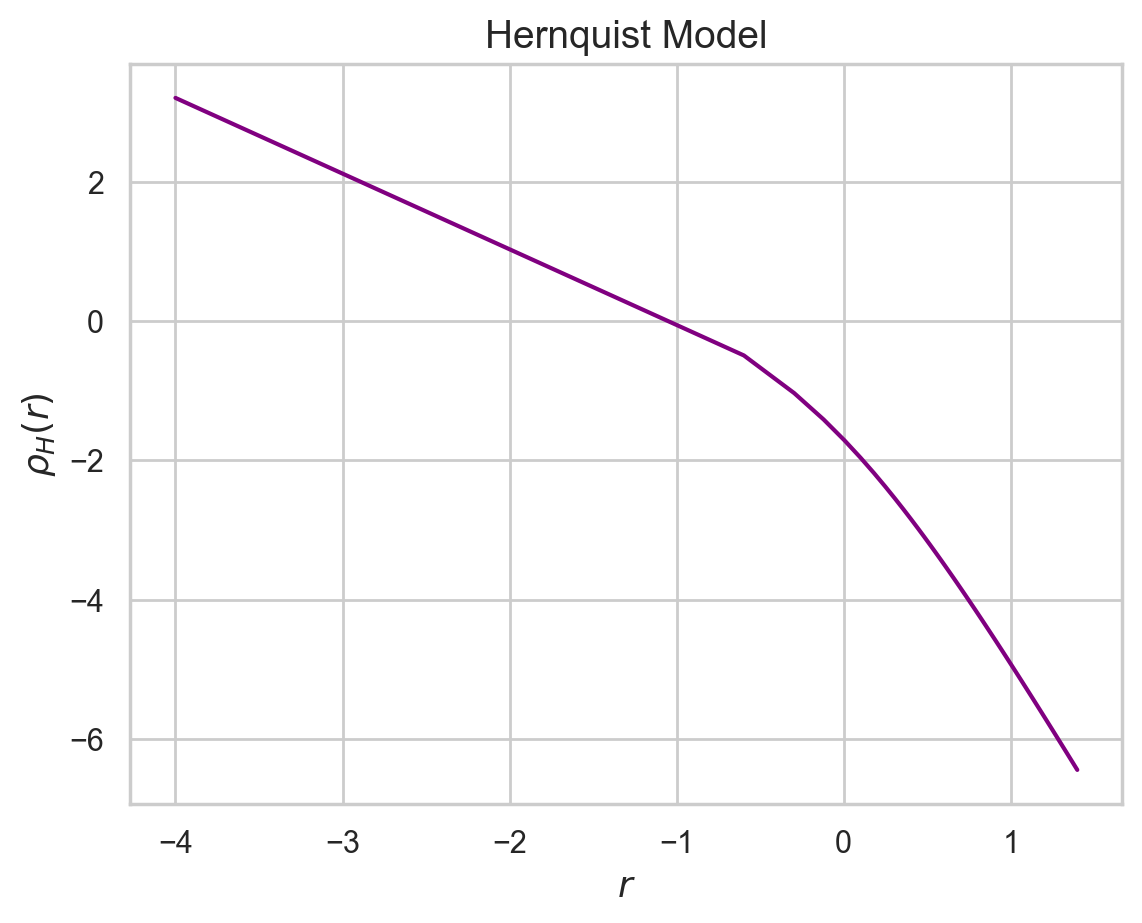

In [5]:
sns.set(style="whitegrid")
plt.plot(np.log10(radii_i), np.log10(rho), color='purple')
plt.title('Hernquist Model', fontsize=14)
plt.xlabel(r'$r$', fontsize=13)
plt.ylabel(r'$\rho_H(r)$', fontsize=13)

### Positions Sampling

In [6]:
def cumulative(r, Rs): 
    
    '''Cumulative distribution to sample radial positions.'''
    
    return (r**2) / ( (Rs+r)**2)


def inv_cumulative(Rs, N):
    
    P = np.random.uniform(0, max(Pr_i), size = N)
    
    return (np.sqrt(P) * Rs) / (1 - np.sqrt(P))

In [7]:
Pr_i   = cumulative(radii_i, Rs)
np.max(Pr_i)

0.9245562130177515

In [8]:
radii   = inv_cumulative(Rs, N)

P_theta = np.random.uniform(0, 1, N)
theta   = np.arccos(1 - 2 * P_theta)

P_phi   = np.random.uniform(0, 1, N)
phi     = P_phi * 2 * np.pi

In [9]:

def calculate_radius(r, percentage):
    # Calcolo del raggio entro il quale sta una certa percentuale di particelle
    
    sorted_r = np.sort(r)
    
    index = int(len(sorted_r) * percentage / 100)
    radius = sorted_r[index]
    
    return radius


percentage = 75  # percentuale delle particelle da considerare

radius = calculate_radius(radii, percentage)
print(f"Raggio entro il quale si trova il {percentage}% delle particelle: {radius}")
print(radius/Rs)


Raggio entro il quale si trova il 75% delle particelle: 5.041360825742174
5.041360825742174


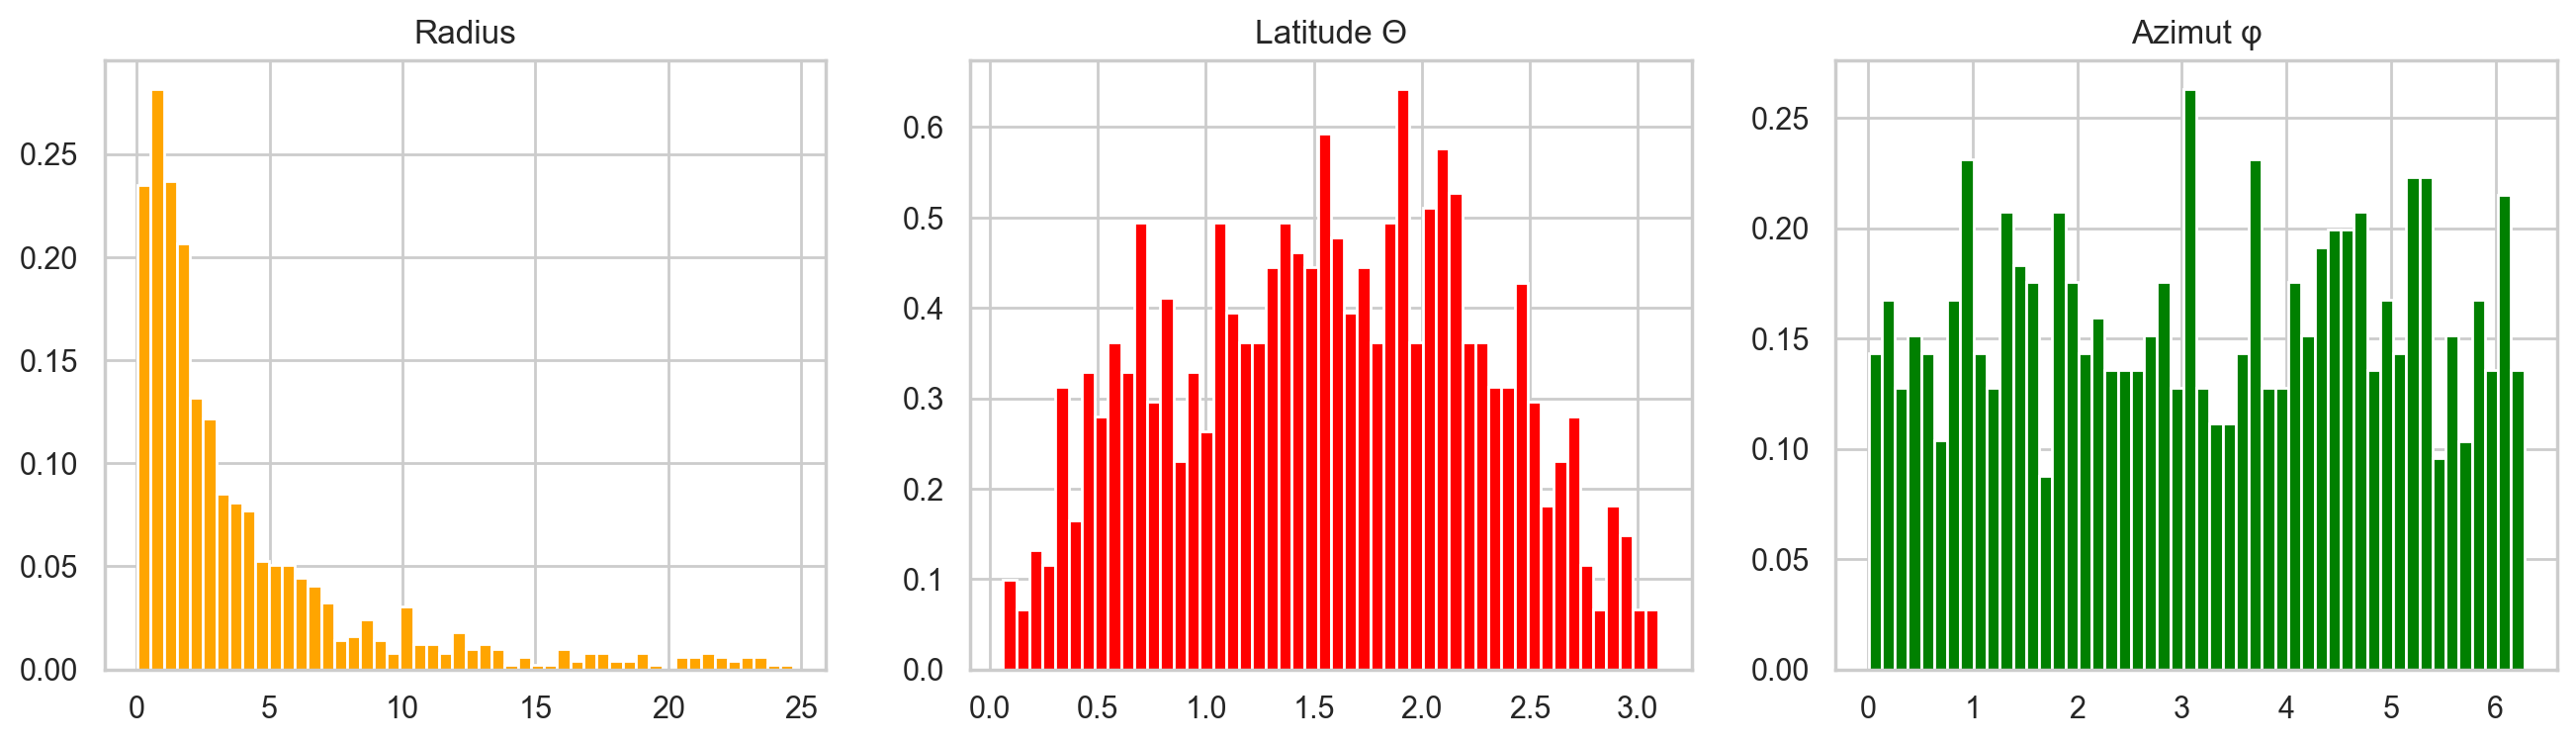

In [10]:
fig, axs = plt.subplots(1,3,figsize=(16,4))

axs[0].hist(radii, bins=50, density=True, color='orange')
axs[0].set_title('Radius')
#axs[0].axvline(x = radius * Rs, linestyle='--', color='red', label = r'$5Rs (75% of particles)$')
#axs[0].set_xlabel('0 ≤ a ≤ 1')
#axs[0].legend()

# Plot the histogram of theta on the second column
axs[1].hist(theta, bins=50, density=True, color='red')
axs[1].set_title('Latitude Θ')
#axs[1].set_xlabel('Radians')

# Plot the histogram of phi on the third column
axs[2].hist(phi, bins=50, density=True, color='green')
axs[2].set_title('Azimut φ')
#axs[2].set_xlabel('Radians')

plt.show()

In [11]:
# cartesian coords
x = radii * np.sin(theta) * np.cos(phi)
y = radii * np.sin(theta) * np.sin(phi)
z = radii * np.cos(theta)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


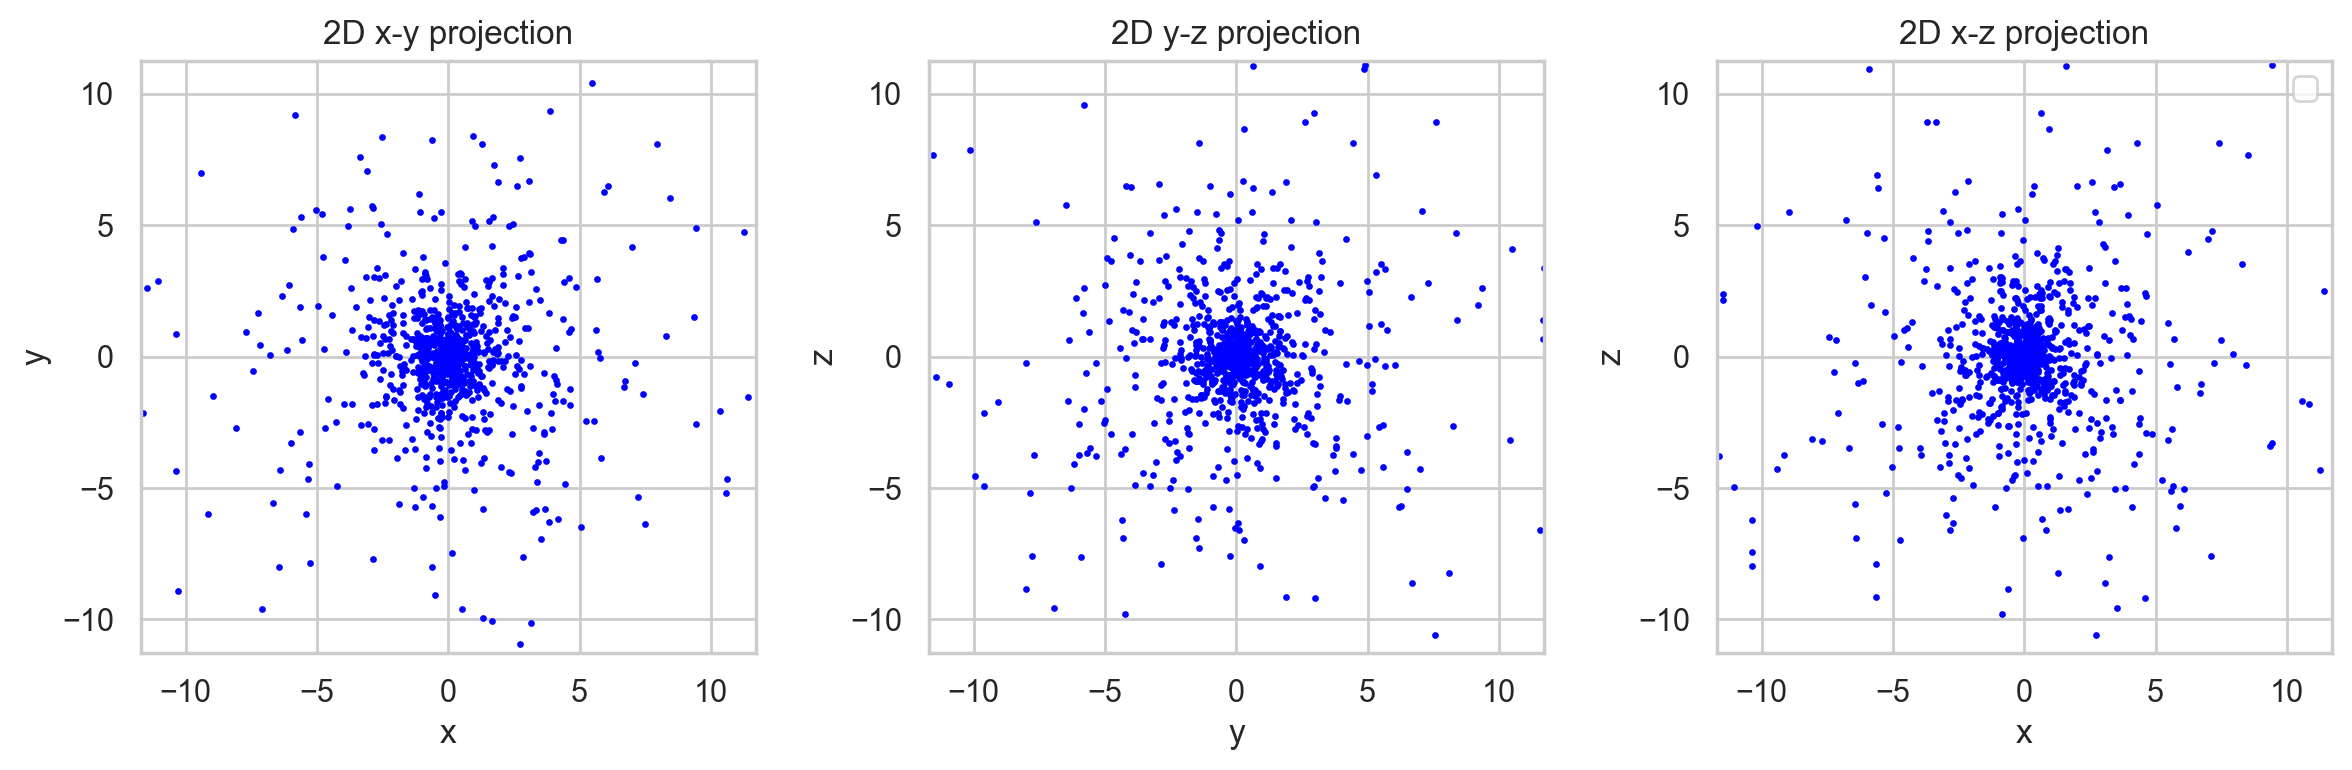

In [12]:
fig, axes = plt.subplots(1, 3, figsize=(12, 4))

theta_lim = np.linspace(0, 2 * np.pi, 150)
a = radius * Rs * np.cos( theta_lim )
c = radius * Rs * np.sin( theta_lim )

axes[0].scatter(x, y, c='blue', s=2)
#axes[0].plot(a, c, c='red', linewidth=1, label=r'75% of particles')
axes[0].axis('equal')
axes[0].set_xlim(-10, 10)
axes[0].set_ylim(-10, 10)
axes[0].set_xlabel('x')
axes[0].set_ylabel('y')
axes[0].set_title('2D x-y projection')

# Projection on y-z plane
axes[1].scatter(y, z, c='blue', s=2)
#axes[1].plot(a, c, c='red', linewidth=1, label=r'75% of particles')
axes[1].axis('equal')
axes[1].set_xlim(-10, 10)
axes[1].set_ylim(-10, 10)
axes[1].set_xlabel('y')
axes[1].set_ylabel('z')
axes[1].set_title('2D y-z projection')


# Projection on x-z plane
axes[2].scatter(x, z, c='blue', s=2)
#axes[2].plot(a, c, c='red', linewidth=1, label=r'75% of particles')
axes[2].axis('equal')
axes[2].set_xlim(-10, 10)
axes[2].set_ylim(-10, 10)
axes[2].set_xlabel('x')
axes[2].set_ylabel('z')
axes[2].set_title('2D x-z projection')

plt.legend()
plt.tight_layout()
plt.show()

# Check the distribution

Text(0, 0.5, '$\\rho_H(r)$')

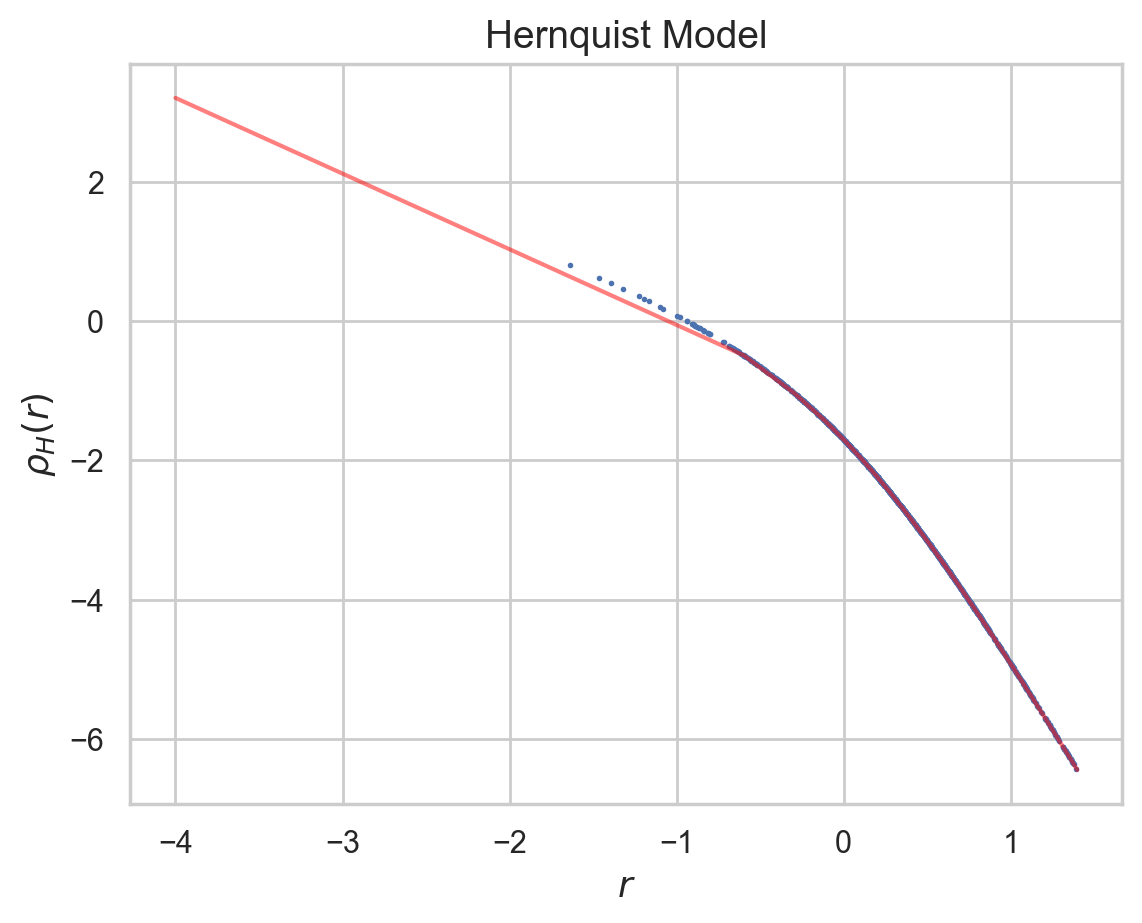

In [13]:
rho_check      = Hernquist(radii, Rs, rho_0)

sns.set(style="whitegrid")
plt.scatter(np.log10(radii), np.log10(rho_check), s=1)
plt.plot(np.log10(radii_i), np.log10(rho), color='red', alpha=0.5)
plt.title('Hernquist Model', fontsize=14)
plt.xlabel(r'$r$', fontsize=13)
plt.ylabel(r'$\rho_H(r)$', fontsize=13)
#plt.xlim(-0.01, 1)

### Potential

The potential is:

$$
    \Phi(r) =-  4 \pi G \rho_0 Rs^2 \frac{1}{2(1+ \frac{r}{Rs})}
$$

In [14]:
def H_potential(radii, Rs, rho_0):
    return - 4 * math.pi * G * rho_0 * Rs**2 * (1 / (2 * (1 + radii/Rs)))

In [15]:
sorted_radii = np.sort(radii)
Psi          = H_potential(sorted_radii, Rs, rho_0)

Text(0, 0.5, '$\\Phi_J(r)$')

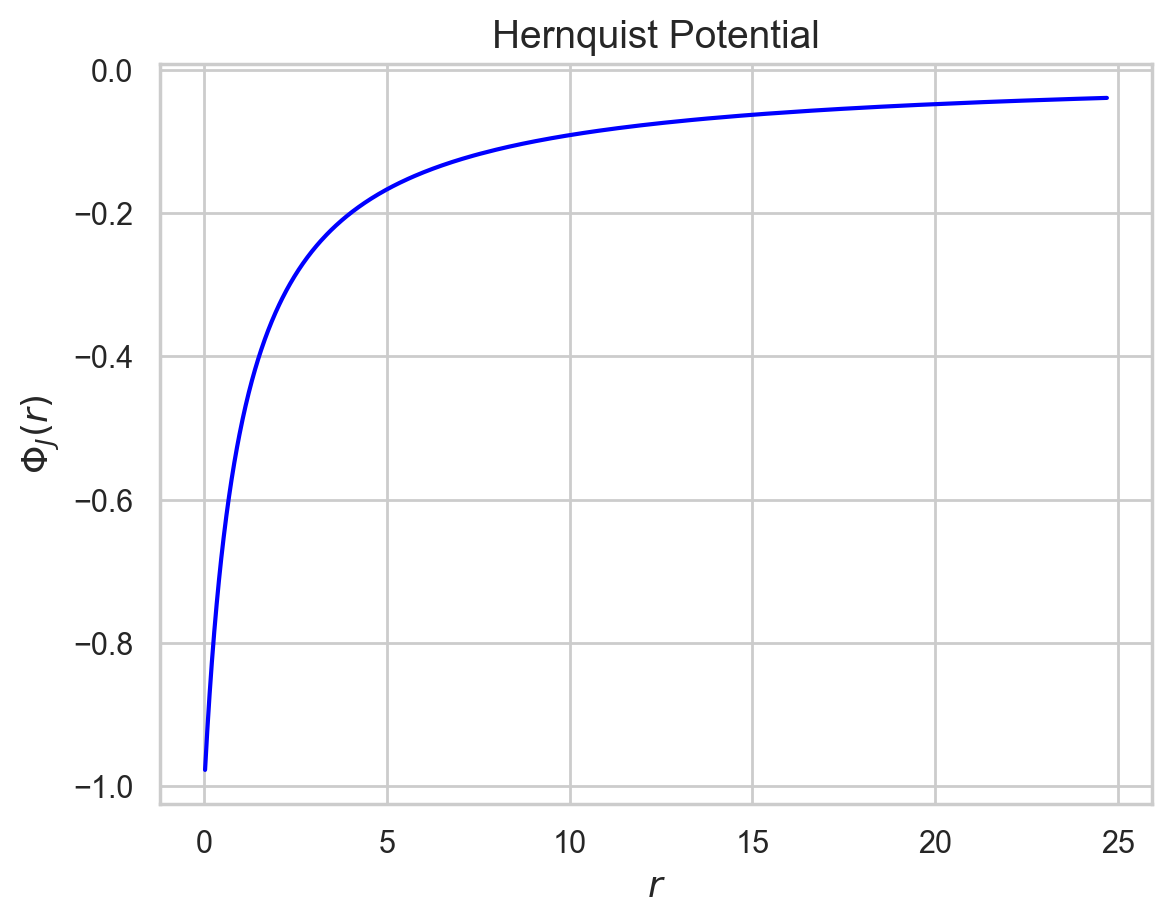

In [16]:
sns.set(style="whitegrid")

plt.plot(sorted_radii, Psi, color='blue')
plt.title('Hernquist Potential', fontsize=14)
plt.xlabel(r'$r$', fontsize=13)
plt.ylabel(r'$\Phi_J(r)$', fontsize=13)

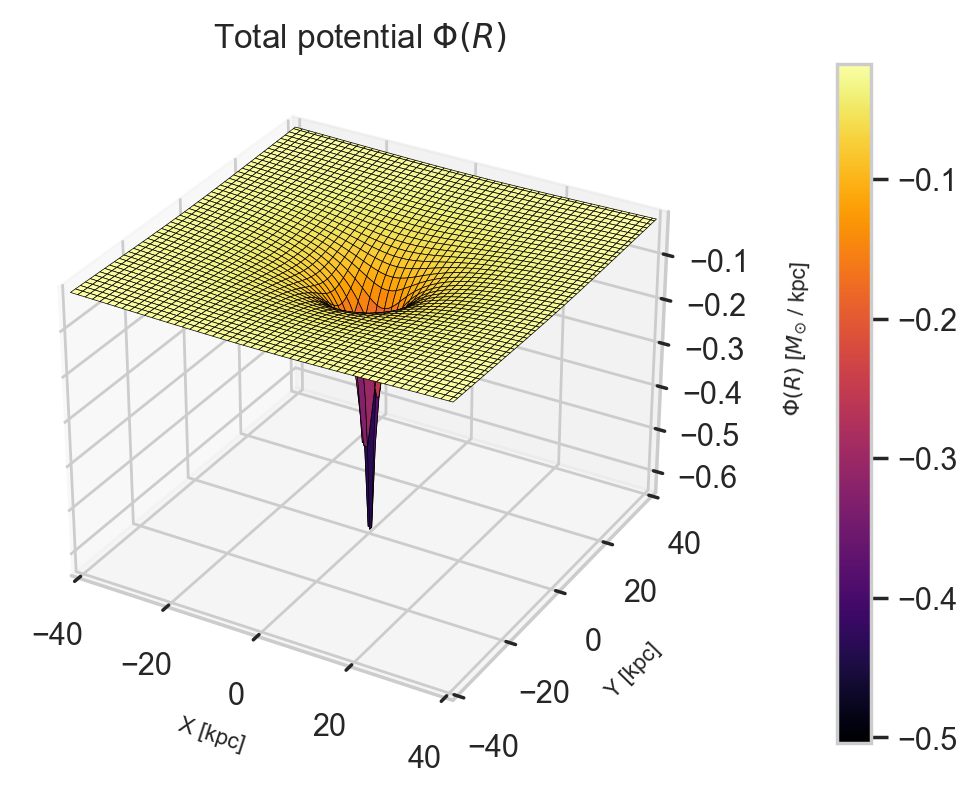

In [17]:
x_pot = np.linspace(-40 * Rs, 40 * Rs, 100)
y_pot = np.linspace(-40 * Rs, 40 * Rs, 100)

X, Y = np.meshgrid(x_pot, y_pot)
Psi_2d = H_potential(np.sqrt(X**2+Y**2), Rs, rho_0)

fig = plt.figure(figsize=(8, 4), tight_layout=True)
ax = fig.add_subplot(1, 1, 1, projection='3d')
image=ax.plot_surface(X, Y, Psi_2d, cmap='inferno', edgecolor='black', lw=0.25)
ax.set_xlabel('X [kpc]', fontsize=8)
ax.set_ylabel('Y [kpc]', fontsize=8)
ax.set_zlabel('\n\n $\Phi(R)$ [$M_{\odot}$ / kpc]', fontsize=8)
ax.set_title(r'Total potential $\Phi(R)$', fontsize=12)
ax.set_xlim(-40 * Rs, 40 * Rs)
ax.set_ylim(-40 * Rs, 40 * Rs)
ax.set_zlim(np.min(Psi_2d), np.max(Psi_2d))
#ax.view_init(35, -75)
plt.tight_layout()
plt.colorbar(image, fraction=0.046, pad=0.09)
#plt.savefig('Total-pot.pdf', bbox_inches='tight');
plt.show()

## Distribution Function

Page 302
$$
    f_H(\epsilon)=\frac{1}{\sqrt{2}(2 \pi)^3 (GM R_s)^{\frac{3}{2} }  } \frac{\sqrt{\epsilon}}{(1- \epsilon)^2} \left[ (1-2\epsilon) (8\epsilon ^2 - 8 \epsilon -3) + \frac{3 sin^{-1} \sqrt{\epsilon}}{\sqrt{\epsilon (1 - \epsilon)}}    \right]
$$
where $\epsilon = -\frac{E R_s}{GM}$

In [18]:
def df_H(epsilon, Rs, G, M):

    #epsilon = (E*Rs)/(G*M)
    term1 = 1 / ( np.sqrt(2) * ((2 * np.pi)**3) * ((G * M * Rs)**(3/2)) )
    term2 = np.sqrt(epsilon) / ((1 - epsilon)**2)
    term3 = (1 - 2 * epsilon) * ((8 * (epsilon**2)) - (8 * epsilon) - 3)
    term4 = (3 * (np.arcsin(np.sqrt(epsilon)) )  ) / (np.sqrt(epsilon * (1 - epsilon)))
    result = term1 * term2 * (term3 + term4)
    
    return result
    

(-0.1, 1.5)

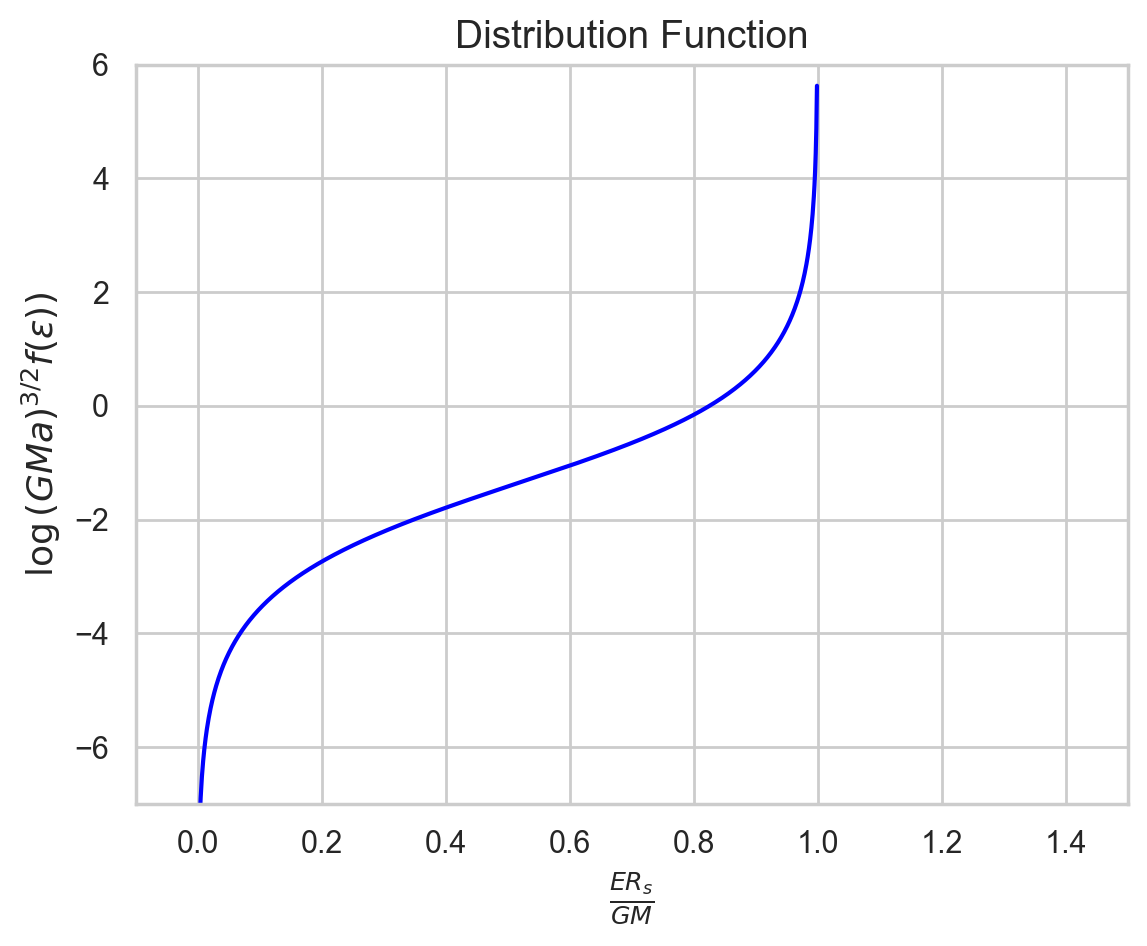

In [19]:
asse_x = np.linspace(0.001, 0.999, N) # come sul libro

E       = asse_x * (G*M/Rs)
epsilon = (E*Rs)/(G*M)
df      = df_H(epsilon, Rs, G, M)

asse_y = np.log10(((G*M*Rs)**(3/2)) * df)

sns.set(style="whitegrid")


plt.plot(E, asse_y, color='blue')
plt.title(r'Distribution Function', fontsize=14)
plt.xlabel(r'$\frac{ER_s}{GM}$', fontsize=13)
plt.ylabel(r'$\log{(GMa)^{3/2} f(\varepsilon))}$', fontsize=13)

plt.ylim(-7,6)
plt.xlim(-0.1,1.5)

## MC rejection method

Devo campionare $f(\epsilon) 4 \pi v^2 dv$ dove $\epsilon = \Psi - \frac{1}{2}v^2$

$v = \sqrt{2(\epsilon - \Psi)}$

Cioè $\frac{f(\epsilon) 8 \pi \sqrt{\epsilon - \Psi}}{\sqrt{2}}$

In [21]:
def df_H_q(Psi,q, Rs, G, M):

    "Uguale a prima ma prendo in input q e lo trasformo in epsilon"
    epsilon = -Psi * (1 - q**2)
    term1 = 1 / ( np.sqrt(2) * ((2 * np.pi)**3) * ((G * M * Rs)**(3/2)) )
    term2 = np.sqrt(epsilon) / ((1 - epsilon)**2)
    term3 = (1 - 2 * epsilon) * ((8 * (epsilon**2)) - (8 * epsilon) - 3)
    term4 = (3 * (np.arcsin(np.sqrt(epsilon)) )  ) / (np.sqrt(epsilon * (1 - epsilon)))
    result = term1 * term2 * (term3 + term4)
    
    return result

In [156]:
'''
# non tiene conto del ciclo su Psi

x_mc = []
y_mc = []

for psi in (Psi):
    q = random.uniform(0,1)
    currentF = 8 * np.pi * np.sqrt(2) * df_H_q(psi,q, Rs, G, M) * (-psi) * np.sqrt(-psi) * q**2
    max_F = np.max(currentF)
    
    y_rand = random.uniform(0, max_F)
    
    while(y_rand > 8 * np.pi * np.sqrt(2) * df_H_q(psi,q, Rs, G, M) * (-psi) * np.sqrt(-psi) * q**2
         ):
        q = random.uniform(0, 1)
          
        currentF = 8 * np.pi * np.sqrt(2) * df_H_q(psi,q, Rs, G, M) * (-psi) * np.sqrt(-psi) * q**2
        max_F = np.max(currentF)
    
        y_rand = random.uniform(0, max_F)
    x_mc.append(q)
    y_mc.append(y_rand)
          
x_mc = np.array(x_mc)
y_mc = np.array(ys)
'''

In [22]:
# mio, tiene conto del ciclo su Psi
y_mc = []
x_mc = []

# creo le q (o x)
q  = np.linspace(0.00001, 0.99999, N) 

# ciclo su Psi. per ogni valore del potenziale, voglio solo una v
for j in range(N): 
    Psi_j = Psi[j]

    # calcolo la funzione con un solo valore di Psi
    func = 8 * np.pi * np.sqrt(2) * df_H_q(Psi_j,q, Rs, G, M) * (-Psi_j) * np.sqrt(-Psi_j) * q**2

    # trovo il massimo della funzione e la q corrispondente
    func_max = np.max(func)
    eps_max = q[int(np.argmax(func))]


    # trovo una x e una y a caso che stanno entro eps_max e func_max
    #se la y sta sotto la funzione, la tengo e riparto con un nuovo Psi da capo
    # se la y non sta sotto la funzione, ri-genero una coppia x-y finchè non trovo un y che sta sotto la funzione
    while True:
        
        x_rand = np.random.uniform(0.00001, eps_max)
        y_rand = np.random.uniform(0, func_max)

        if y_rand < 8 * np.pi * np.sqrt(2) * df_H_q(Psi_j, x_rand, Rs, G, M) * (-Psi_j) * np.sqrt(-Psi_j) * x_rand**2:
    
            y_mc.append(y_rand)
            x_mc.append(x_rand)
            break

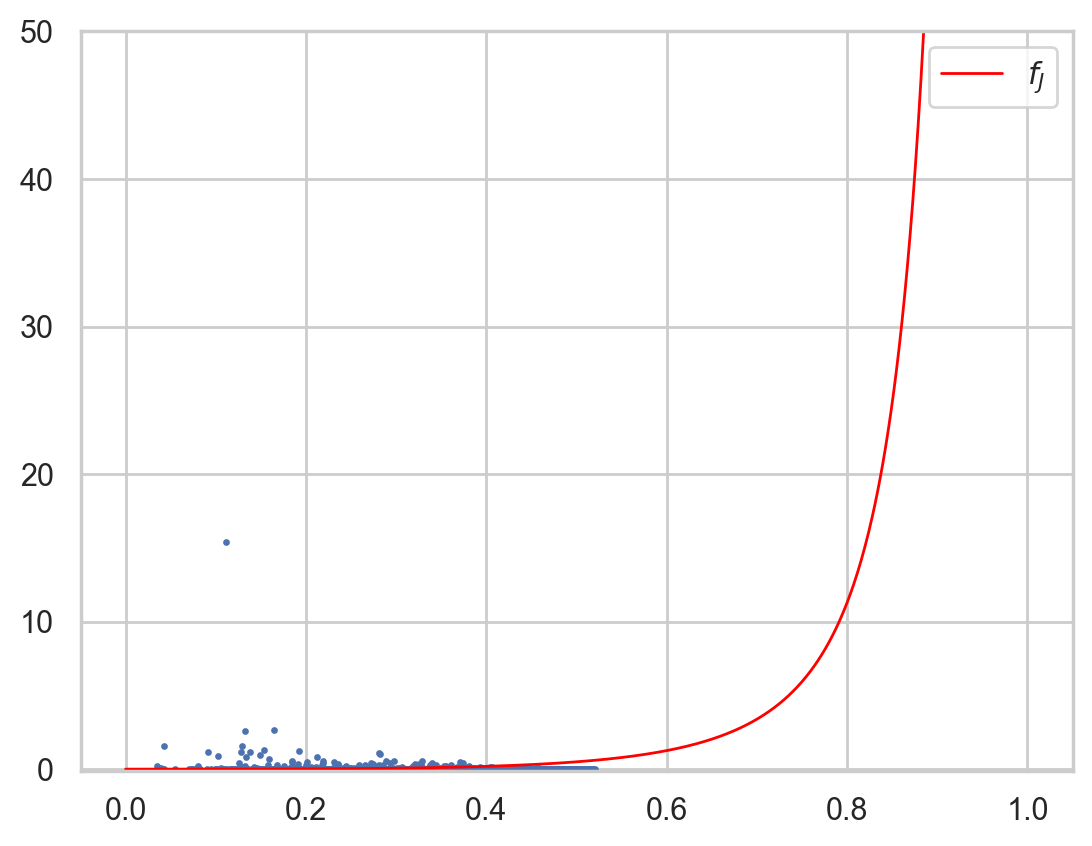

In [27]:
#plt.hist((x_mc),50, density=True, alpha = 1)
func1 = (df_H(q, Rs, G, M) * 8 * np.pi * np.sqrt( -Psi_j+ q )) / np.sqrt(2)
plt.scatter(x_mc, y_mc, s=2)
plt.plot(q, func1, color='red', label=fr'$f_J$', linewidth=1)
plt.ylim(-0.1,50)
#plt.xlim(-0.1,1)
plt.legend()

# ???

### Velocities

In [30]:
#v = np.sqrt(2*(x_mc-Psi))
v = x_mc * np.sqrt(-2*Psi)

v_theta_cdf = np.random.uniform(0,1,N)
v_theta = np.arccos(1 - 2 * v_theta_cdf)

v_phi = np.random.uniform(0, 2 * np.pi, size=N) 

In [31]:
v_x = v * np.sin(v_theta) * np.cos(v_phi)
v_y = v * np.sin(v_theta) * np.sin(v_phi)
v_z = v * np.cos(v_theta)

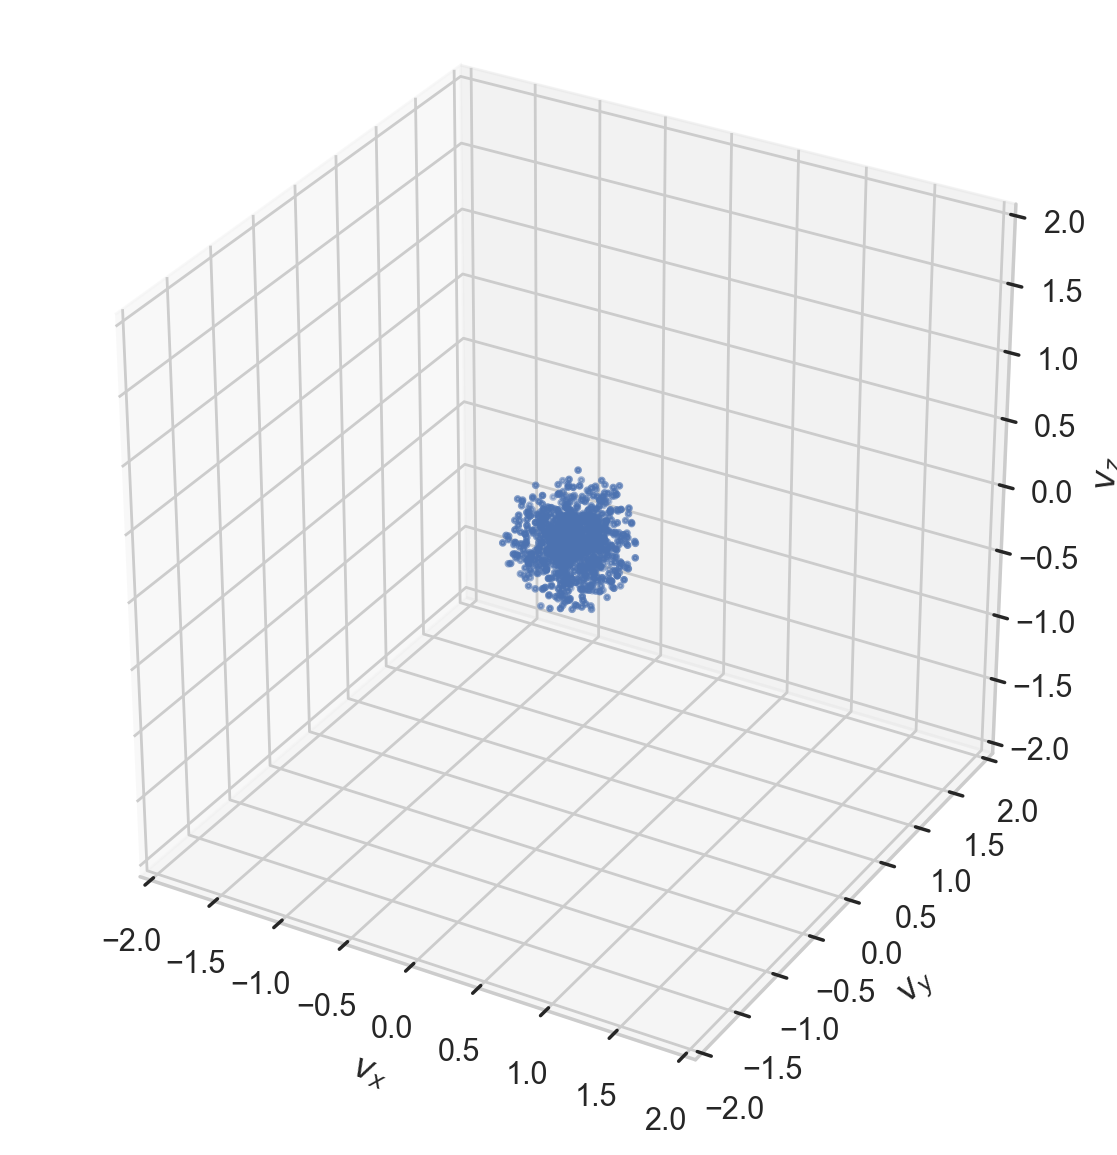

In [32]:
fig = plt.figure(figsize = (7,7))
ax = fig.add_subplot(projection='3d')

ax.set_xlim(-2,2)
ax.set_ylim(-2,2)
ax.set_zlim(-2,2)
ax.scatter(v_x, v_y, v_z, c = 'b', s=3)
ax.set_aspect('equal')
ax.set_xlabel(r'$v_x$')
ax.set_ylabel(r'$v_y$')
ax.set_zlabel(r'$v_z$')
plt.show();

## Initial conditions

In [33]:
# creating the input file
m_arr = m * np.ones(N)
dim = 3


with open ('in_H.txt', 'w+') as f:
    f.write(str(N) + '\n')
    f.write(f'{dim}' + '\n')
    f.write('0' + '\n')
    for m_i in m_arr:
        f.write(f'{m_i}' + '\n')
    for i in range(N):
        f.write(f'{x[i]} {y[i]} {z[i]}' + '\n')
    for j in range(N):
        f.write(f'{v_x[j]} {v_y[j]} {v_z[j]}' + '\n')

In [34]:
T_dyn = (3*np.pi/(16*G*rho_0))**(1/2)
print("Dynamical Time: ", T_dyn)

V = 4/3 * np.pi * Rs**3
epsilon = round(1/10 * (V/N)**(1/3), 4)
print("Epsilon: ", epsilon)

T_sim = np.round(5 * T_dyn)
print("Simulation time: ", T_sim)

dt = 1/20
theta = 0.2
t_out = dt

Dynamical Time:  1.9238247452427961
Epsilon:  0.0161
Simulation time:  10.0


In [35]:
print('./treecode in=in_H.txt  dtime='+ str(dt) +' theta='+str(theta)+ ' tstop='+str(T_sim) +' dtout='+str(t_out)+  ' out=out_H.txt >logout_H.txt')


./treecode in=in_H.txt  dtime=0.05 theta=0.2 tstop=10.0 dtout=0.05 out=out_H.txt >logout_H.txt


# ANALYSIS

In [39]:
lines = pd.read_csv('out_H.txt', names = list(range(3)), sep = '\s+')
N_particles = N
s = N*3+3

t_s  = np.array([lines.iloc[2::s,0].copy().dropna()]).flatten()
m_s  = np.array([lines.iloc[i::s,0].copy().dropna() for i in range(3, N+3)])
x_s  = np.array([lines.iloc[i::s,0].copy().dropna() for i in range(N+3, 2*N+3)])
y_s  = np.array([lines.iloc[i::s,1].copy().dropna() for i in range(N+3, 2*N+3)])
z_s  = np.array([lines.iloc[i::s,2].copy().dropna() for i in range(N+3, 2*N+3)])
vx_s = np.array([lines.iloc[i::s,0].copy().dropna() for i in range(2*N+3, 3*N+3)])
vy_s = np.array([lines.iloc[i::s,1].copy().dropna() for i in range(2*N+3, 3*N+3)])
vz_s = np.array([lines.iloc[i::s,2].copy().dropna() for i in range(2*N+3, 3*N+3)])
#calcolo raggi
r_s = np.sqrt(x_s**2 + y_s**2 + z_s**2)

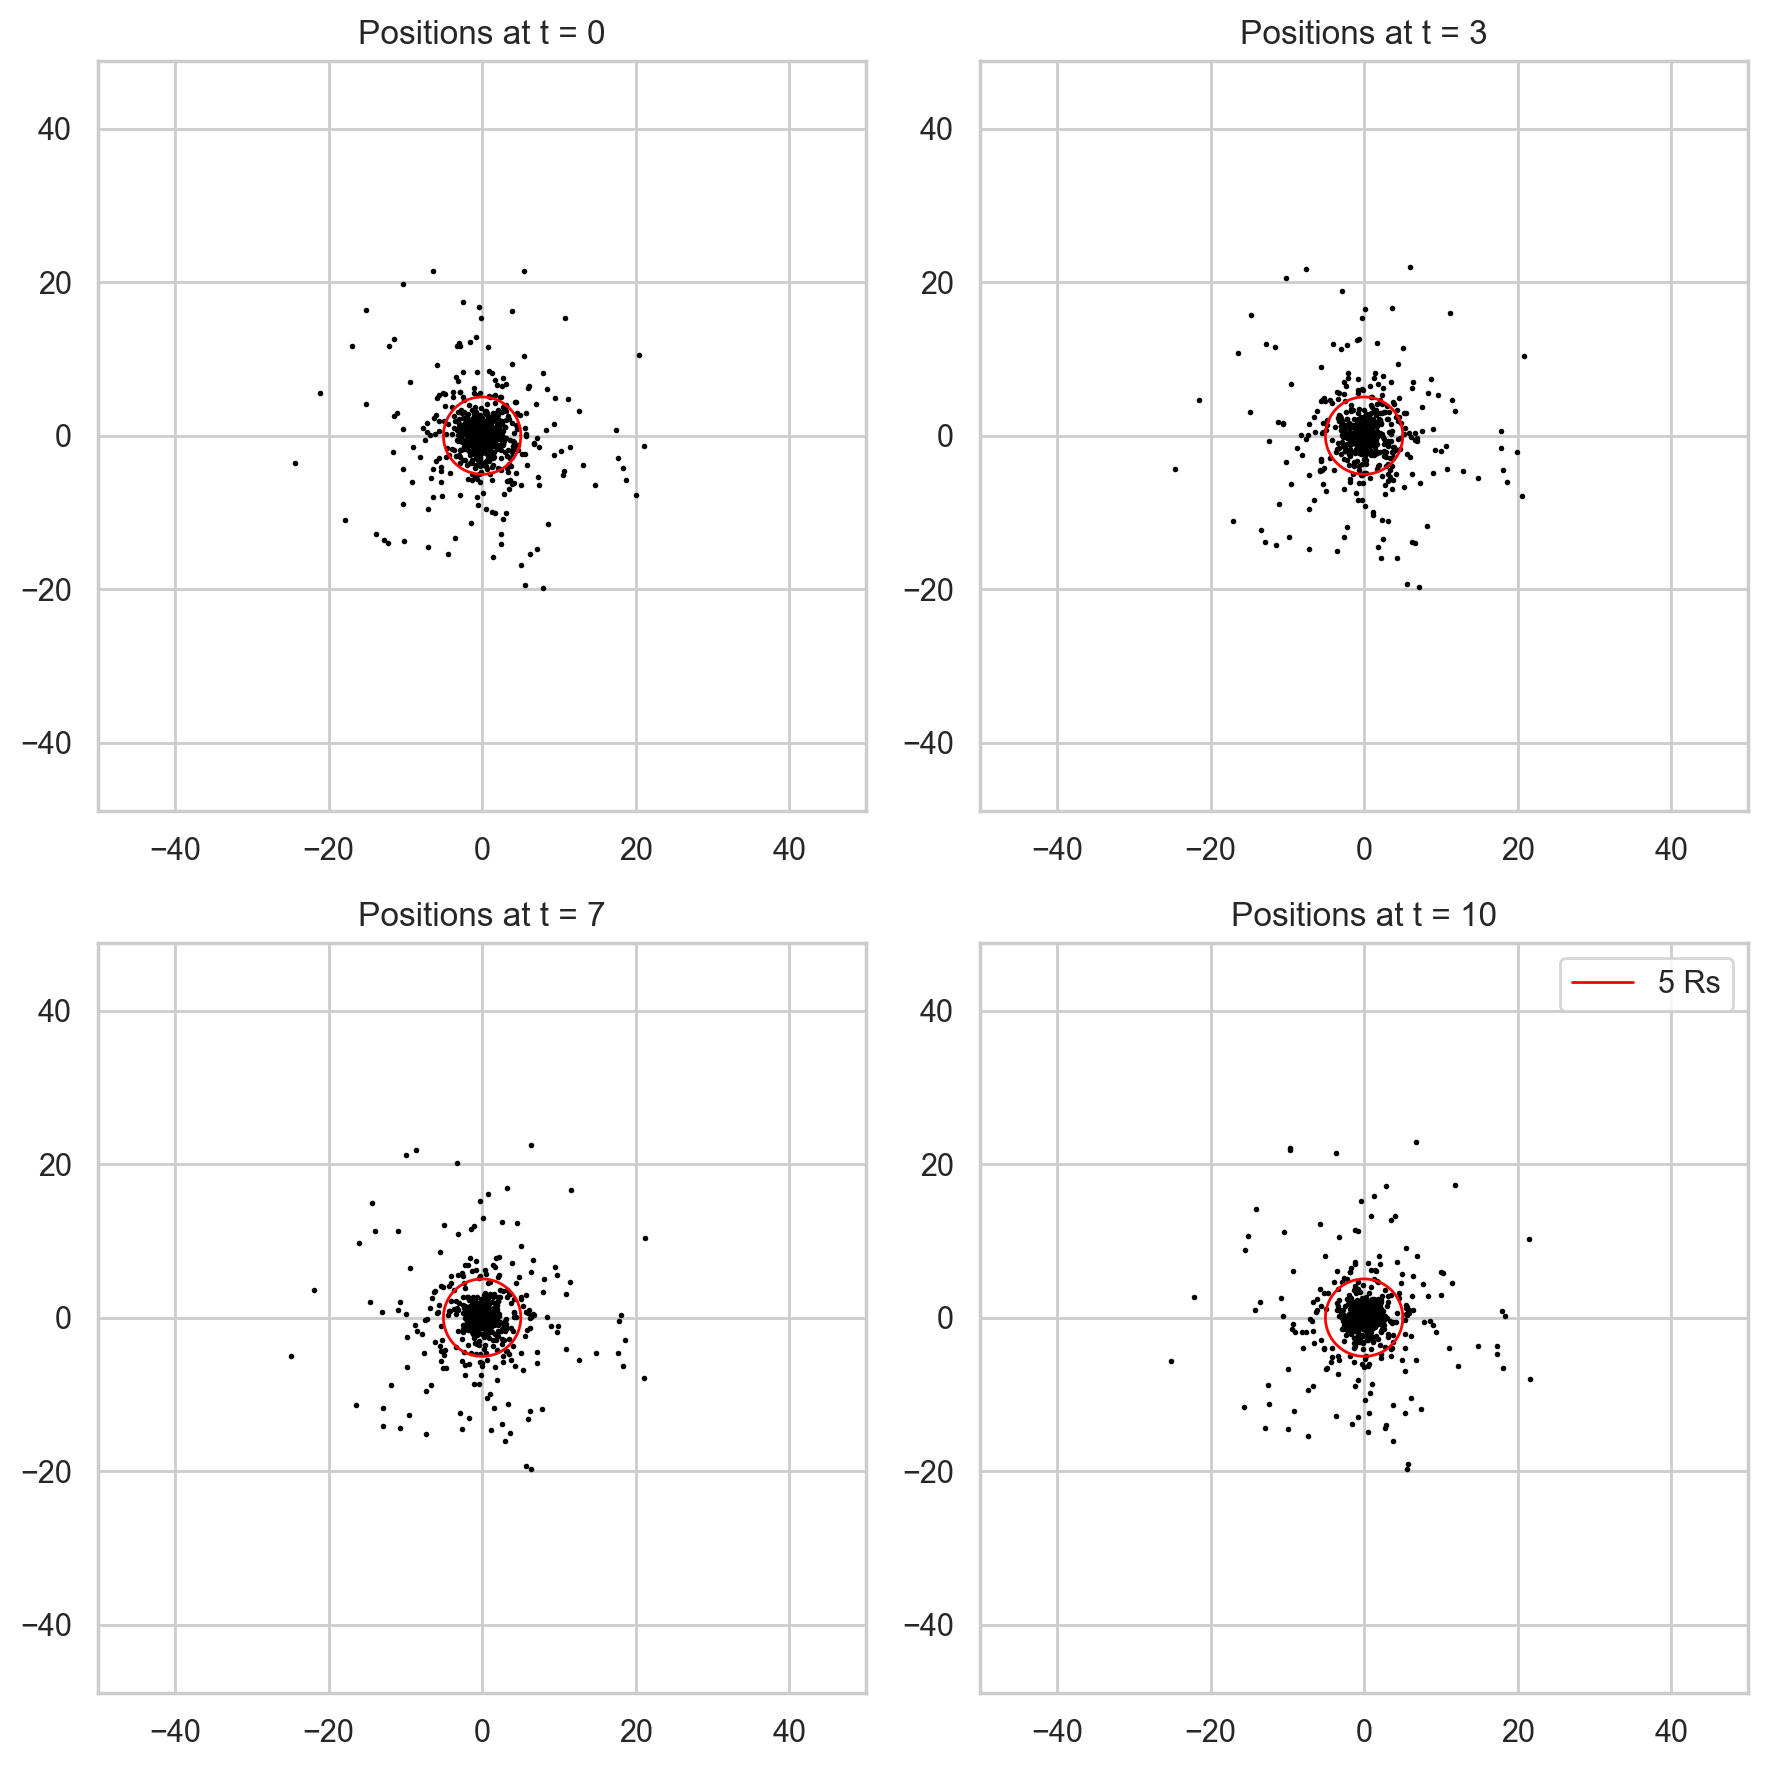

In [40]:
t0 = 0
t1 = int(np.round(len(t_s) * 1 / 3))
t2 = int(np.round(len(t_s) * 2 / 3))
t3 = -1

# Set Seaborn style
sns.set(style="whitegrid")

fig, ax = plt.subplots(2, 2, tight_layout=True, figsize=(9, 9)) 

# Plot 1
ax[0][0].scatter(x_s[:, t0], y_s[:, t0], c='black', alpha=1, s=1)#, label='Particles at t=0')

ax[0][0].set_title(f'Positions at t = {int(np.round(t_s[t0]))}')
ax[0][0].plot(a, c, c='red', linewidth=1)#, label=r'5 Rs')
ax[0][0].axis('equal')
#ax[0][0].legend(fontsize='large')
ax[0][0].set_xlim(-50, 50)
ax[0][0].set_ylim(-50, 50)


# Plot 2
ax[0][1].scatter(x_s[:, t1], y_s[:, t1], c='black', alpha=1, s=1)#, label='Particles at t1')

ax[0][1].set_title(f'Positions at t = {int(np.round(t_s[t1]))}')
ax[0][1].plot(a, c, c='red', linewidth=1)#, label=r'5 Rs')
ax[0][1].axis('equal')
#ax[0][1].legend(fontsize='large')
ax[0][1].set_xlim(-50, 50)
ax[0][1].set_ylim(-50, 50)


# Plot 3
ax[1][0].scatter(x_s[:, t2], y_s[:, t2], c='black', alpha=1, s=1)#, label='Particles at t2')

ax[1][0].set_title(f'Positions at t = {int(np.round(t_s[t2]))}')
ax[1][0].plot(a, c, c='red', linewidth=1)#, label=r'5 Rs')
ax[1][0].axis('equal')
#ax[1][0].legend(fontsize='large')
ax[1][0].set_xlim(-50, 50)
ax[1][0].set_ylim(-50, 50)

# Plot 4
ax[1][1].scatter(x_s[:, t3], y_s[:, t3], color='black', alpha=1, s=1)#, label='Particles at t=T_sim')
ax[1][1].plot(a, c, c='red', linewidth=1, label=r'5 Rs')
ax[1][1].set_title(f'Positions at t = {int(np.round(t_s[t3]))}')
ax[1][1].axis('equal')
ax[1][1].legend()
ax[1][1].set_xlim(-50, 50)
ax[1][1].set_ylim(-50, 50)

plt.show()

  0%|          | 0/201 [00:00<?, ?it/s]

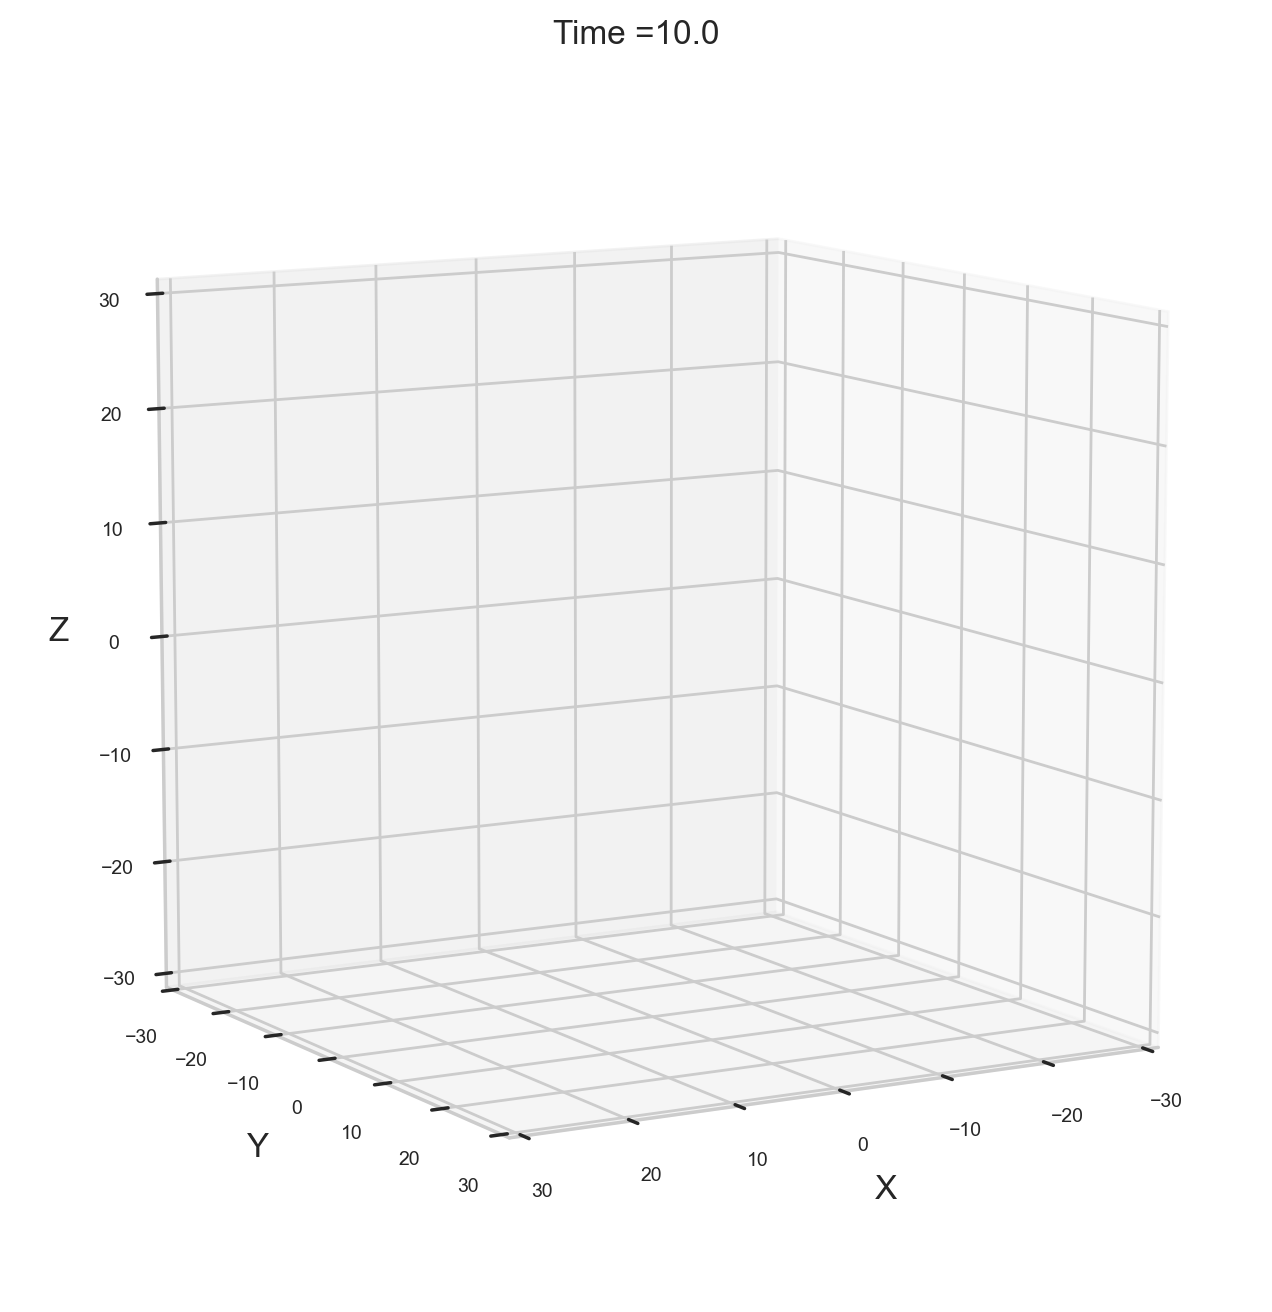

In [50]:
# ANIMATION


from tqdm.notebook import tqdm
import matplotlib.animation as animation
from matplotlib.animation import FuncAnimation

#plot------------------------------------------------------------------------------

fig = plt.figure(figsize = (8,8))
ax  = fig.add_subplot(projection='3d')
ax.set_aspect('equal')

ax.view_init(elev=10, azim=60)
ax.set_xlim(-30,30)
ax.set_ylim(-30,30)
ax.set_zlim(-30,30)


ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.tick_params(axis='x', labelsize=7)
ax.tick_params(axis='y', labelsize=7)
ax.tick_params(axis='z', labelsize=7)


#animation--------------------------------------------------------------------------------
scatters, = ax.plot([], [], [], 'o', markersize='0.8', alpha=0.3)


def init():
    scatters.set_data([], [])
    scatters.set_3d_properties([])
    return scatters,

def animate_time(i): 
    scatters.set_data(x_s[:,i], y_s[:,i])
    scatters.set_3d_properties(z_s[:,i])
    ax.set_title('Time =' + str(np.round((np.array(t_s))[i])))
        
    return scatters,


num_frames = len(t_s)/2
animazione = FuncAnimation(fig, animate_time, frames=tqdm(range(len(t_s))), interval=100, init_func=init) #frames = num_frames interval =100

theta_ = np.linspace(0,2*np.pi,1000)

writergif = animation.PillowWriter(fps=30)
animazione.save(f'Hernquist.gif', writer = writergif)
#plt.show()

plt.rcParams['animation.html'] = 'html5'


### Lagrangian radius

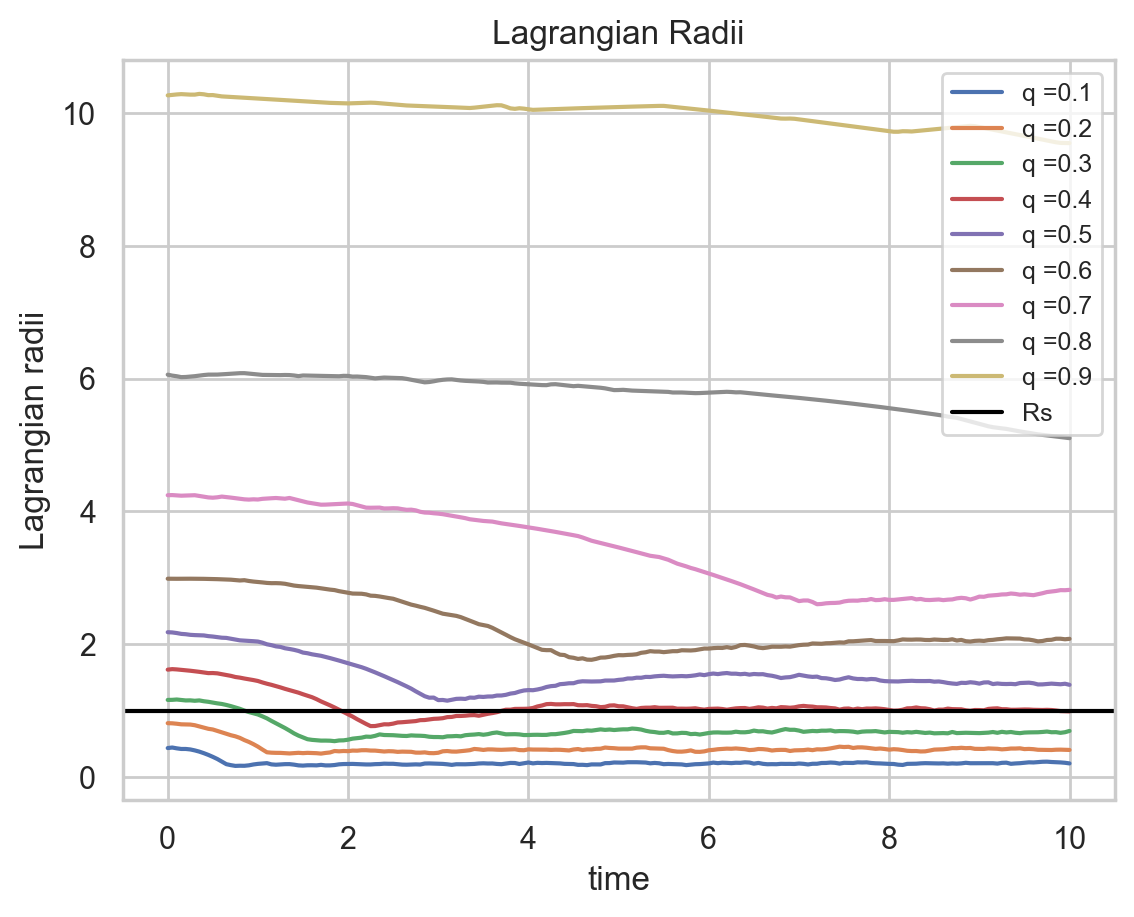

In [41]:
def Lagrangian_Radius(radius_array, quantile):
    
    L_radii = []
    
    # cycle over N_time_output
    for i in range(len(radius_array[0])):
        
        radii_sorted = np.sort(radius_array[:,i])
        mask = radii_sorted < np.quantile(radii_sorted, quantile)
        L_radii.append(np.max(radii_sorted[mask]))
        
    return np.array(L_radii)

##############################################################################
quantiles = np.linspace(0.1, 0.9, 9)

for q in quantiles:
    
    L = Lagrangian_Radius(r_s, round(q,1))
    plt.plot(t_s, L, label='q ='+str(round(q,1)))   
    
plt.axhline(Rs, label='Rs', color='black')
plt.ylabel('Lagrangian radii')
plt.xlabel('time')
plt.title('Lagrangian Radii')
plt.margins(.05)
plt.legend(fontsize=9)

### Distribution check

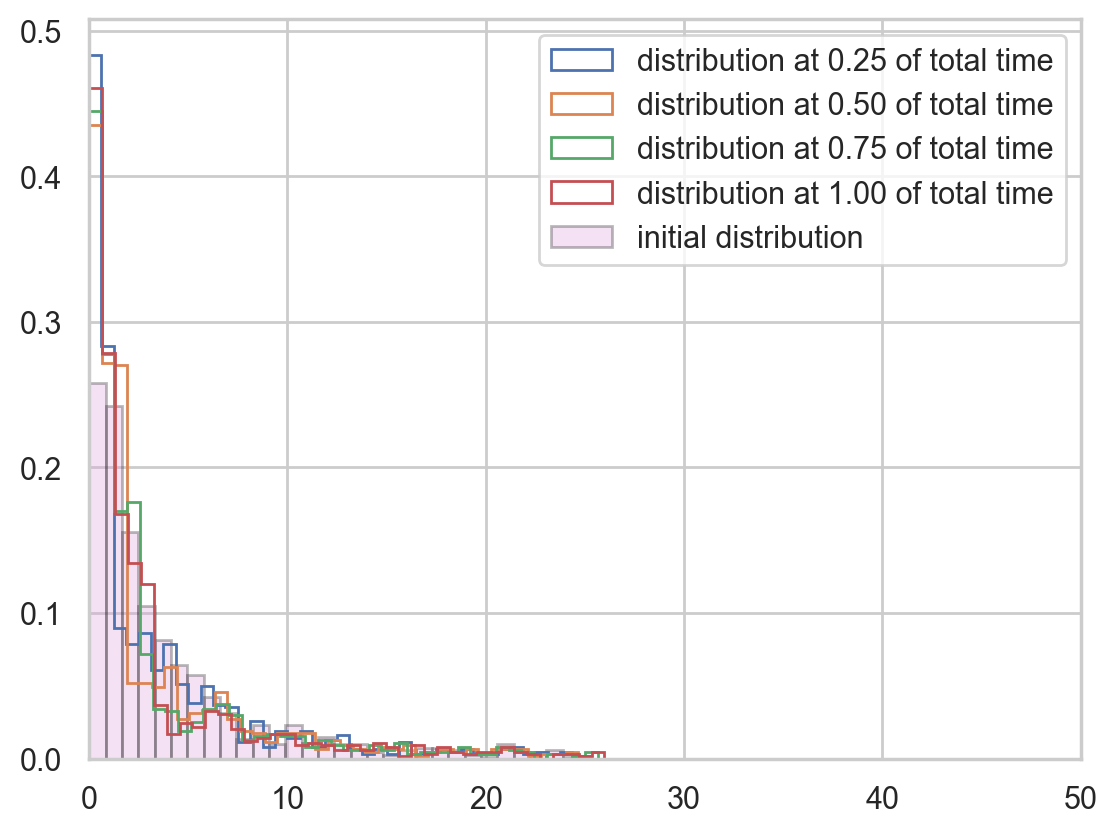

In [43]:
def distribution(frac):
    t = int(len(t_s)*frac)
    r_t = r_s[:,t-1]
    plt.hist(r_t[r_t<50], bins=40, density=True, histtype='step', label='distribution at %.2f of total time' %frac)

    
f=[0.25,0.5,0.75,1] #vectors of fractions
for frac in f:
    distribution(frac)
    
plt.hist(radii[radii<50], bins=30, density=True, alpha=0.3, color='plum', ec='k', histtype='bar', label='initial distribution');
plt.xlim(0,50)
plt.legend();

# CoM

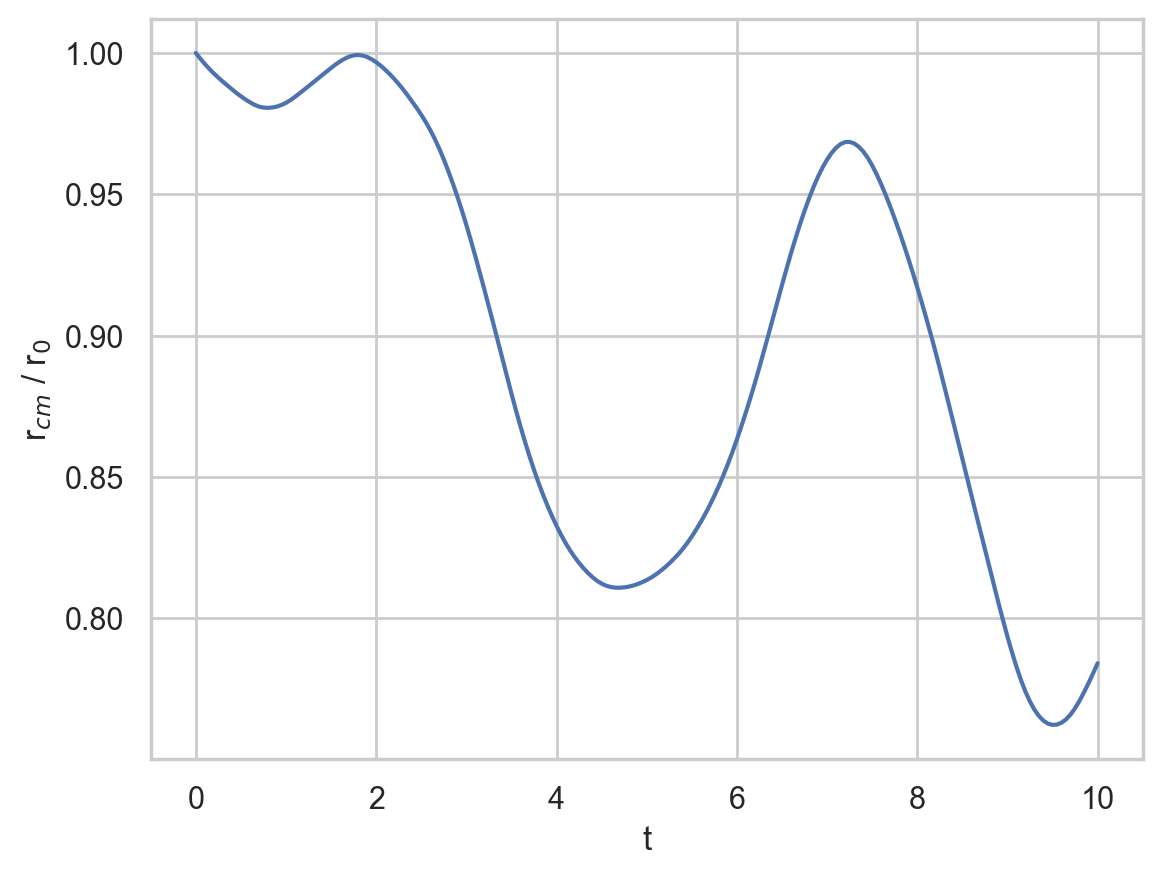

In [44]:
mu = m / M

x_cm = mu * np.sum(x_s, axis = 0)
y_cm = mu * np.sum(y_s, axis = 0)
z_cm = mu * np.sum(z_s, axis = 0)
r_cm = np.sqrt(x_cm**2 + y_cm**2 + z_cm**2)

plt.plot(t_s, r_cm/r_cm[0])
plt.ylabel('r$_{cm}$ / r$_{0}$')
plt.xlabel('t');

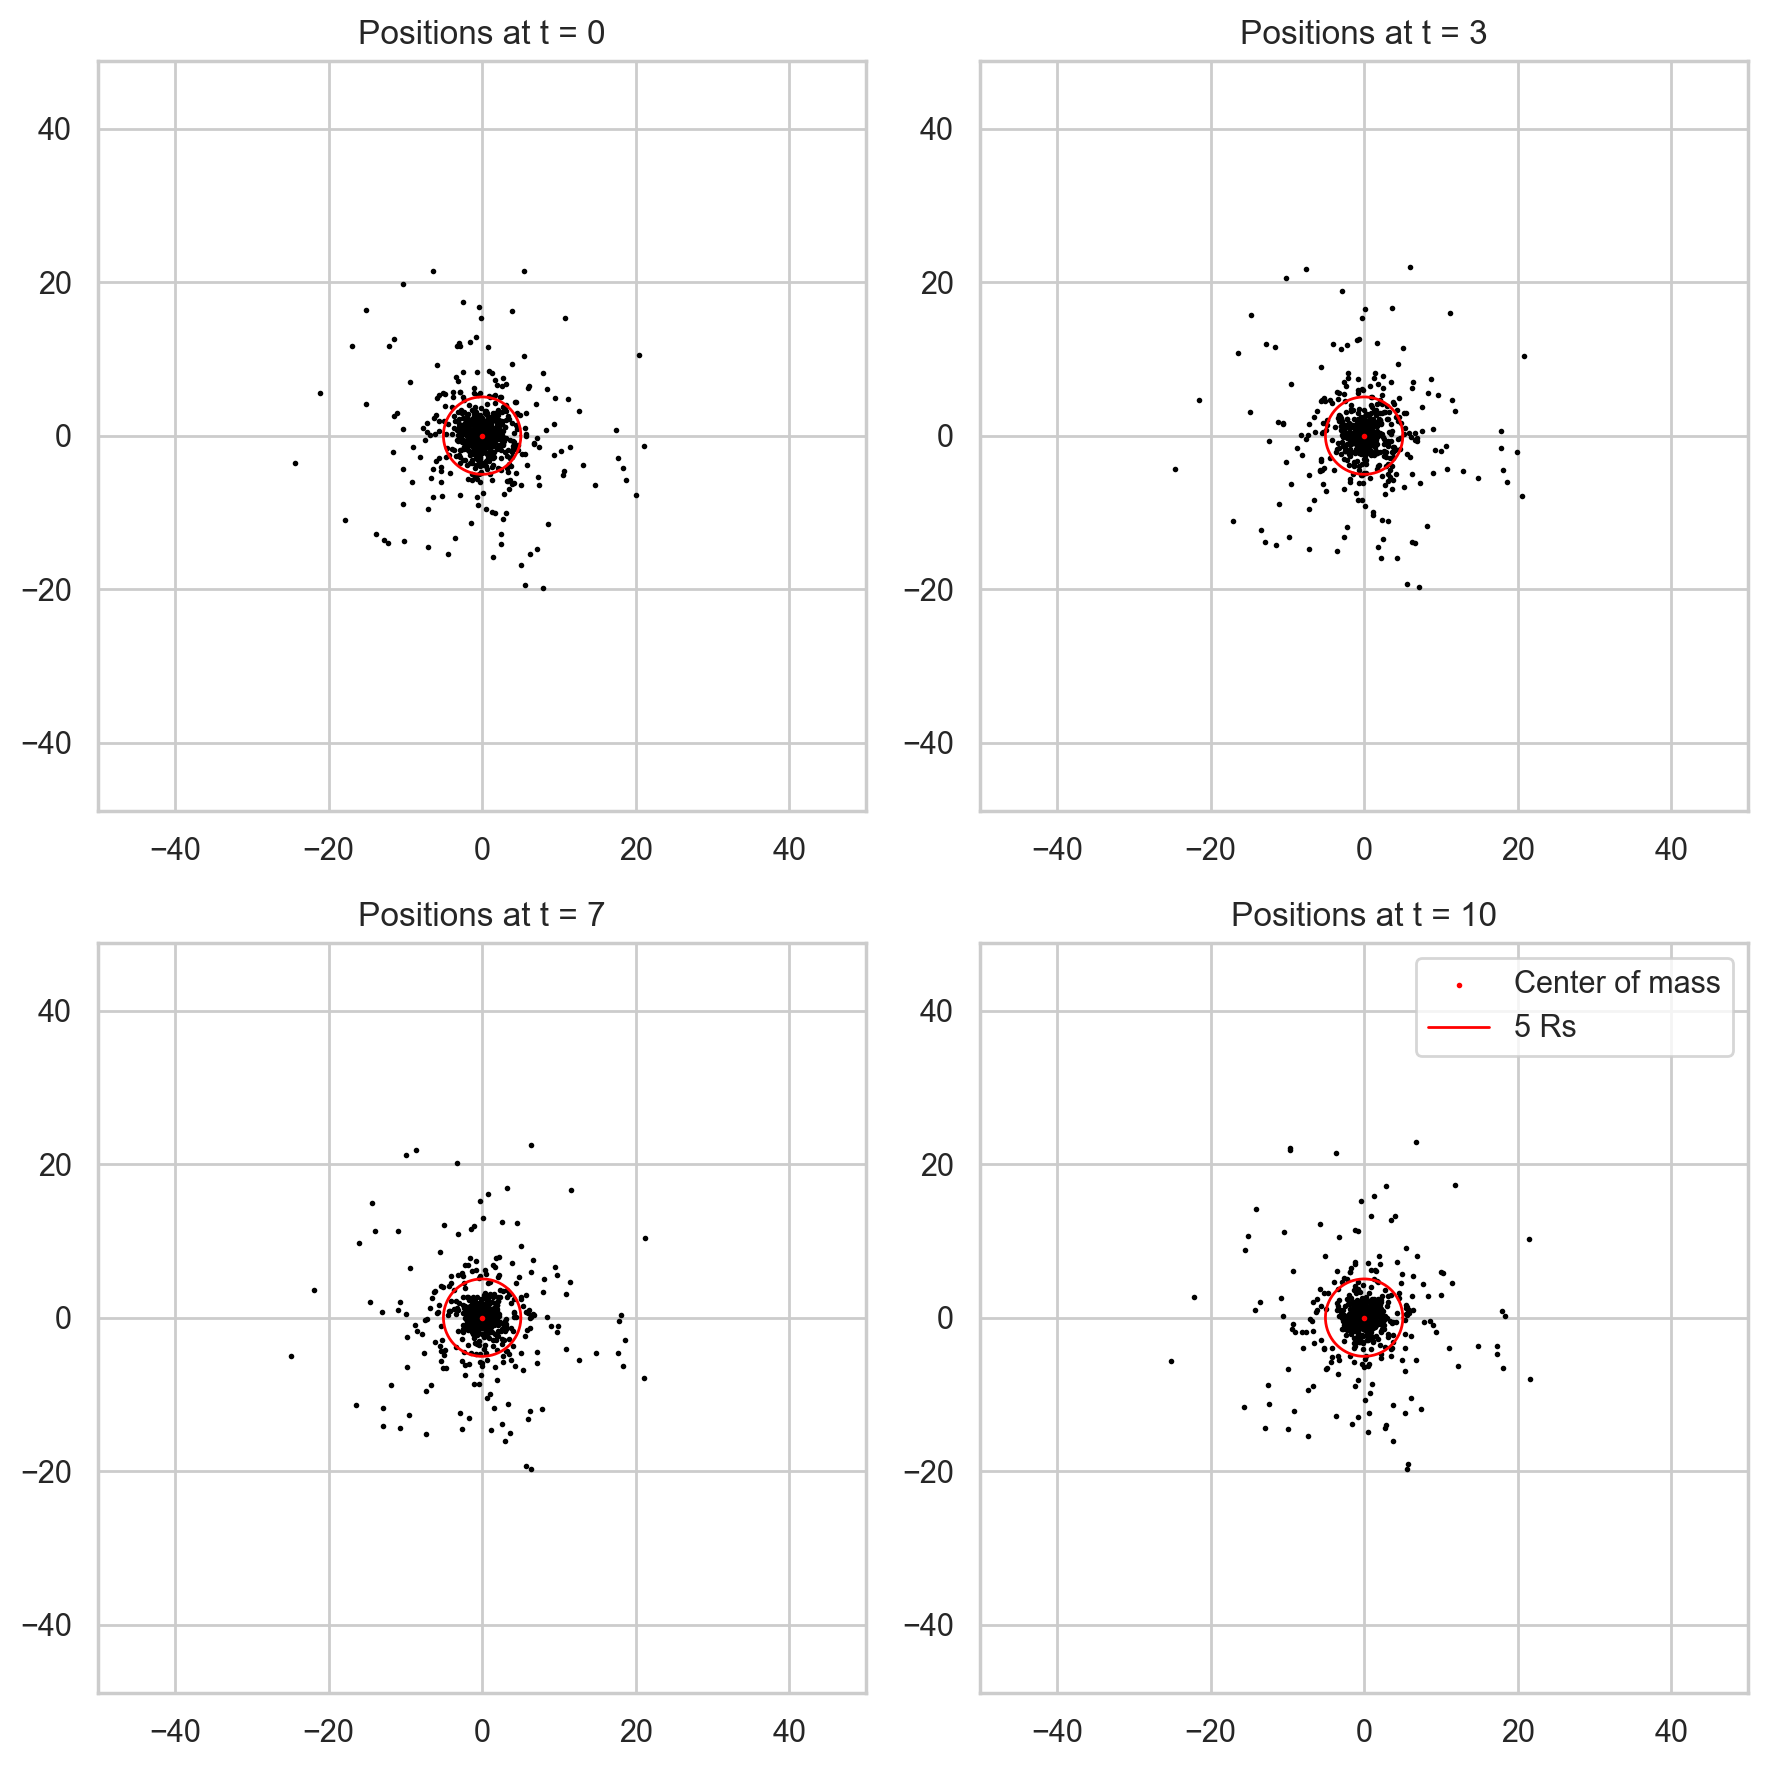

In [45]:
t0 = 0
t1 = int(np.round(len(t_s) * 1 / 3))
t2 = int(np.round(len(t_s) * 2 / 3))
t3 = -1

# Set Seaborn style
sns.set(style="whitegrid")

fig, ax = plt.subplots(2, 2, tight_layout=True, figsize=(9, 9)) 

# Plot 1
ax[0][0].scatter(x_s[:, t0], y_s[:, t0], c='black', alpha=1, s=1)#, label='Particles at t=0')

ax[0][0].scatter(x_cm[t0], y_cm[t0], c='red', alpha=1, s=1)#, label='Particles at t=0')

ax[0][0].set_title(f'Positions at t = {int(np.round(t_s[t0]))}')
ax[0][0].plot(a, c, c='red', linewidth=1)#, label=r'5 Rs')
ax[0][0].axis('equal')
#ax[0][0].legend(fontsize='large')
ax[0][0].set_xlim(-50, 50)
ax[0][0].set_ylim(-50, 50)


# Plot 2
ax[0][1].scatter(x_s[:, t1], y_s[:, t1], c='black', alpha=1, s=1)#, label='Particles at t1')
ax[0][1].scatter(x_cm[t1], y_cm[t1], c='red', alpha=1, s=1)#, label='Particles at t=0')


ax[0][1].set_title(f'Positions at t = {int(np.round(t_s[t1]))}')
ax[0][1].plot(a, c, c='red', linewidth=1)#, label=r'5 Rs')
ax[0][1].axis('equal')
#ax[0][1].legend(fontsize='large')
ax[0][1].set_xlim(-50, 50)
ax[0][1].set_ylim(-50, 50)


# Plot 3
ax[1][0].scatter(x_s[:, t2], y_s[:, t2], c='black', alpha=1, s=1)#, label='Particles at t2')
ax[1][0].scatter(x_cm[t2], y_cm[t2], c='red', alpha=1, s=1)#, label='Particles at t=0')

ax[1][0].set_title(f'Positions at t = {int(np.round(t_s[t2]))}')
ax[1][0].plot(a, c, c='red', linewidth=1)#, label=r'5 Rs')
ax[1][0].axis('equal')
#ax[1][0].legend(fontsize='large')
ax[1][0].set_xlim(-50, 50)
ax[1][0].set_ylim(-50, 50)

# Plot 4
ax[1][1].scatter(x_s[:, t3], y_s[:, t3], color='black', alpha=1, s=1)#, label='Particles at t=T_sim')
ax[1][1].scatter(x_cm[t3], y_cm[t3], c='red', alpha=1, s=1, label='Center of mass')

ax[1][1].plot(a, c, c='red', linewidth=1, label=r'5 Rs')
ax[1][1].set_title(f'Positions at t = {int(np.round(t_s[t3]))}')
ax[1][1].axis('equal')
ax[1][1].legend()
ax[1][1].set_xlim(-50, 50)
ax[1][1].set_ylim(-50, 50)

plt.show()